# Quiz-4 and Final Project - Group 2

In [166]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram, plot_bloch_multivector, plot_bloch_vector
from qiskit.quantum_info import Statevector, Operator
from qiskit.circuit import Parameter
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np
from qiskit.circuit import Parameter
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
np.float = float    
np.int = int   #module 'numpy' has no attribute 'int'
np.object = object    #module 'numpy' has no attribute 'object'
np.bool = bool    #module 'numpy' has no attribute 'bool'
import warnings
# Filter warnings
warnings.filterwarnings('ignore')


## Quiz 4

### Dataset

In [167]:
import pandas as pd
data = pd.read_csv('results.csv')

In [168]:
data.head()

,home_team,away_team,home_goals,away_goals,result,season
0,Sheffield United,Liverpool,1.0,1.0,D,2006-2007
1,Arsenal,Aston Villa,1.0,1.0,D,2006-2007
2,Everton,Watford,2.0,1.0,H,2006-2007
3,Newcastle United,Wigan Athletic,2.0,1.0,H,2006-2007
4,Portsmouth,Blackburn Rovers,3.0,0.0,H,2006-2007


In [169]:
data_13_14 = data[data['season'] == '2013-2014']
data_13_14_up = data_13_14.drop(['season', 'home_goals', 'away_goals'], axis=1)

data_13_14_no_draws = data_13_14_up[data_13_14_up['result'] != 'D']

data_13_14_no_draws.head()


,home_team,away_team,result
2660,Liverpool,Stoke City,H
2661,Arsenal,Aston Villa,A
2663,Sunderland,Fulham,A
2664,West Bromwich Albion,Southampton,A
2665,West Ham United,Cardiff City,H


In [170]:
# Filter matches where Liverpool is either the home team or away team
liverpool_matches = data_13_14_no_draws[(data_13_14_no_draws['home_team'] == 'Liverpool') | 
                                        (data_13_14_no_draws['away_team'] == 'Liverpool')]


liverpool_matches


,home_team,away_team,result
2660,Liverpool,Stoke City,H
2677,Aston Villa,Liverpool,A
2687,Liverpool,Manchester United,H
2701,Liverpool,Southampton,A
2718,Sunderland,Liverpool,A
2724,Liverpool,Crystal Palace,H
2742,Liverpool,West Bromwich Albion,H
2757,Arsenal,Liverpool,H
2763,Liverpool,Fulham,H
2787,Hull City,Liverpool,H


In [171]:
def classify_liverpool_result(row):
    # Check if Liverpool is the home team and won the match
    if row['home_team'] == 'Liverpool' and row['result'] == 'H':
        return 1
    # Check if Liverpool is the away team and won the match 
    elif row['away_team'] == 'Liverpool' and row['result'] == 'A':
        return 1
    else:
        return 0 # Liverpool did not win the match
        
liverpool_matches['liverpool_result'] = liverpool_matches.apply(classify_liverpool_result, axis=1)

In [172]:
# Drop the 'result' column as it is no longer needed after classification
liverpool_matches = liverpool_matches.drop(['result'], axis=1)
# Display the updated DataFrame
liverpool_matches

,home_team,away_team,liverpool_result
2660,Liverpool,Stoke City,1
2677,Aston Villa,Liverpool,1
2687,Liverpool,Manchester United,1
2701,Liverpool,Southampton,0
2718,Sunderland,Liverpool,1
2724,Liverpool,Crystal Palace,1
2742,Liverpool,West Bromwich Albion,1
2757,Arsenal,Liverpool,0
2763,Liverpool,Fulham,1
2787,Hull City,Liverpool,0


In [173]:
# Add a new column 'liverpool_home_away' to indicate if Liverpool is playing at home or away
# 1 indicates a home game, 0 indicates an away game
liverpool_matches['liverpool_home_away'] = liverpool_matches.apply(
    lambda row: 1 if row['home_team'] == 'Liverpool' else 0, axis=1
)

In [174]:
# Add a new column 'opponent_team' to indicate the opponent team
# If Liverpool is the home team, 'opponent_team' will be the away team
# If Liverpool is the away team, 'opponent_team' will be the home team
liverpool_matches['opponent_team'] = liverpool_matches.apply(
    lambda row: row['away_team'] if row['home_team'] == 'Liverpool' else row['home_team'], axis=1
)

In [175]:
liverpool_matches

,home_team,away_team,liverpool_result,liverpool_home_away,opponent_team
2660,Liverpool,Stoke City,1,1,Stoke City
2677,Aston Villa,Liverpool,1,0,Aston Villa
2687,Liverpool,Manchester United,1,1,Manchester United
2701,Liverpool,Southampton,0,1,Southampton
2718,Sunderland,Liverpool,1,0,Sunderland
2724,Liverpool,Crystal Palace,1,1,Crystal Palace
2742,Liverpool,West Bromwich Albion,1,1,West Bromwich Albion
2757,Arsenal,Liverpool,0,0,Arsenal
2763,Liverpool,Fulham,1,1,Fulham
2787,Hull City,Liverpool,0,0,Hull City


In [176]:
unique_opponent_teams = liverpool_matches['opponent_team'].unique()
# Display the unique opponent teams
unique_opponent_teams

array(['Stoke City', 'Aston Villa', 'Manchester United', 'Southampton',
       'Sunderland', 'Crystal Palace', 'West Bromwich Albion', 'Arsenal',
       'Fulham', 'Hull City', 'Norwich City', 'West Ham United',
       'Tottenham Hotspur', 'Cardiff City', 'Manchester City', 'Chelsea',
       'Everton', 'Swansea City', 'Newcastle United'], dtype=object)

In [177]:
opponent_team_mapping = {team: i+2 for i, team in enumerate(unique_opponent_teams)}
liverpool_matches['opponent_team_mapped'] = liverpool_matches['opponent_team'].map(opponent_team_mapping)
opponent_team_mapping

{'Stoke City': 2,
 'Aston Villa': 3,
 'Manchester United': 4,
 'Southampton': 5,
 'Sunderland': 6,
 'Crystal Palace': 7,
 'West Bromwich Albion': 8,
 'Arsenal': 9,
 'Fulham': 10,
 'Hull City': 11,
 'Norwich City': 12,
 'West Ham United': 13,
 'Tottenham Hotspur': 14,
 'Cardiff City': 15,
 'Manchester City': 16,
 'Chelsea': 17,
 'Everton': 18,
 'Swansea City': 19,
 'Newcastle United': 20}

In [178]:
opponent_team_mapping = {team: i+2 for i, team in enumerate(unique_opponent_teams)}
liverpool_matches['opponent_team_mapped'] = liverpool_matches['opponent_team'].map(opponent_team_mapping)
liverpool_matches

,home_team,away_team,liverpool_result,liverpool_home_away,opponent_team,opponent_team_mapped
2660,Liverpool,Stoke City,1,1,Stoke City,2
2677,Aston Villa,Liverpool,1,0,Aston Villa,3
2687,Liverpool,Manchester United,1,1,Manchester United,4
2701,Liverpool,Southampton,0,1,Southampton,5
2718,Sunderland,Liverpool,1,0,Sunderland,6
2724,Liverpool,Crystal Palace,1,1,Crystal Palace,7
2742,Liverpool,West Bromwich Albion,1,1,West Bromwich Albion,8
2757,Arsenal,Liverpool,0,0,Arsenal,9
2763,Liverpool,Fulham,1,1,Fulham,10
2787,Hull City,Liverpool,0,0,Hull City,11


### Classical (Random Forest Classifier)

In [179]:
# Define the feature set and labels
X = liverpool_matches[['liverpool_home_away', 'opponent_team_mapped']]
y = liverpool_matches['liverpool_result']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Initialize and train the Random Forest classifier
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)

# Predict the results on the test set
y_pred_rf = rf_clf.predict(X_test)

# Calculate metrics for Random Forest
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
specificity_rf = conf_matrix_rf[0, 0] / (conf_matrix_rf[0, 0] + conf_matrix_rf[0, 1]) if (conf_matrix_rf[0, 0] + conf_matrix_rf[0, 1]) != 0 else float('nan')
npv_rf = conf_matrix_rf[0, 0] / (conf_matrix_rf[0, 0] + conf_matrix_rf[1, 0]) if (conf_matrix_rf[0, 0] + conf_matrix_rf[1, 0]) != 0 else float('nan')

# Display the results for Random Forest
print("Confusion Matrix:")
print(conf_matrix_rf)
print(f"Precision (TP/(all predicted positives): {precision_rf:.2f}")
print(f"Recall (TP/ all actual positives)      : {recall_rf:.2f}")
print(f"Specificity TN/(all actual negatives)  : {specificity_rf:.2f}")
print(f"Negative Predictive Value (TN/ All predicted negatives) (NPV): {npv_rf:.2f}")
print(f"Accuracy: {accuracy_rf:.2f}")

Confusion Matrix:
[[0 2]
 [1 7]]
Precision (TP/(all predicted positives): 0.78
Recall (TP/ all actual positives)      : 0.88
Specificity TN/(all actual negatives)  : 0.00
Negative Predictive Value (TN/ All predicted negatives) (NPV): 0.00
Accuracy: 0.70


In [180]:
classifications = rf_clf.predict(liverpool_matches[['liverpool_home_away', 'opponent_team_mapped']])
# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Home/Away': liverpool_matches['liverpool_home_away'].apply(lambda x: 'Yes' if x == 1 else 'No'),
    'Opponent': liverpool_matches['opponent_team'],
    'Real Result': liverpool_matches['liverpool_result'].apply(lambda x: 'Win' if x == 1 else 'Lose'),
    'Predicted Result': ['Win' if x == 1 else 'Lose' for x in classifications]
})

# Add a column to indicate if the prediction is correct
results_df['Correct Prediction'] = results_df['Real Result'] == results_df['Predicted Result']

# Calculate the cumulative points for real and predicted results
results_df['Real Points'] = (liverpool_matches['liverpool_result'] * 3).cumsum()  # Assuming 3 points for a win

# Ensure classifications is a pandas Series with the same index as liverpool_matches
classifications_series = pd.Series(classifications, index=liverpool_matches.index)

# Calculate the cumulative points for predicted results
results_df['Predicted Points'] = (classifications_series * 3).cumsum()  # Assuming 3 points for a win

# Display the results
results_df

,Home/Away,Opponent,Real Result,Predicted Result,Correct Prediction,Real Points,Predicted Points
2660,Yes,Stoke City,Win,Win,True,3,3
2677,No,Aston Villa,Win,Win,True,6,6
2687,Yes,Manchester United,Win,Win,True,9,9
2701,Yes,Southampton,Lose,Win,False,9,12
2718,No,Sunderland,Win,Win,True,12,15
2724,Yes,Crystal Palace,Win,Win,True,15,18
2742,Yes,West Bromwich Albion,Win,Win,True,18,21
2757,No,Arsenal,Lose,Lose,True,18,21
2763,Yes,Fulham,Win,Win,True,21,24
2787,No,Hull City,Lose,Lose,True,21,24


### Quantum 

In [181]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np
from qiskit.circuit import Parameter
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score

# Define the quantum parameters
theta1 = Parameter('θ1')
theta2 = Parameter('θ2')
theta3 = Parameter('θ3')

# Create a quantum circuit with one qubit
qc = QuantumCircuit(1)

# Add parameterized gates
qc.rx(theta1, 0)
qc.ry(theta2, 0)
qc.rz(theta3, 0)

# Add a measurement
qc.measure_all()

def classify_match(home_away, opponent_team_mapped, label):
    # Map input features to theta values
    theta1_value = home_away * np.pi / 2  # θ1 is based on ay status
    theta2_value = opponent_team_mapped * np.pi / 5  # θ2 is based on opponent team mapped to [2,20]
    theta3_value = (home_away + opponent_team_mapped) * np.pi / 4  # θ3 is the sum of home/away and opponenthome/aw

    # Create a new quantum circuit with the mapped values
    bound_qc = QuantumCircuit(1)
    bound_qc.rx(theta1_value, 0)  # θ1
    bound_qc.ry(theta2_value, 0)  # θ2
    bound_qc.rz(theta3_value, 0)  # θ3
    bound_qc.measure_all()

    # Execute the circuit on qasm_simulator for measurement
    backend = Aer.get_backend('qasm_simulator')
    compiled_circuit = transpile(bound_qc, backend)
    job = backend.run(compiled_circuit, shots=1024)
    result = job.result()

    # Get the counts
    counts = result.get_counts()

    # Visualize the results
    plot_histogram(counts)
    plt.show()

    # Classify based on the measurement result
    if counts.get('0', 0) > counts.get('1', 0):
        classification = 0  # Predicts loss
    else:
        classification = 1  # Predicts win

    return classification, label

# Iterate over the liverpool_matches dataframe to classify each match
results = [classify_match(
    row['liverpool_home_away'],        # Home/Away status
    row['opponent_team_mapped'],       # Mapped opponent team
    row['liverpool_result']            # Actual result
) for index, row in liverpool_matches.iterrows()]

# Extract the classifications and actual labels
classifications, labels = zip(*results)

# Calculate confusion matrix and metrics
conf_matrix = confusion_matrix(labels, classifications)
precision = precision_score(labels, classifications)
recall = recall_score(labels, classifications)
accuracy = accuracy_score(labels, classifications)
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
npv = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[1, 0])

# Display the results
print("Confusion Matrix:")
print(conf_matrix)
print(f"Precision (TP/(all predicted positives): {precision:.2f}")
print(f"Recall (TP/ all actual positives)      : {recall:.2f}")
print(f"Specificity TN/(all actual negatives)  : {specificity:.2f}")
print(f"Negative Predictive Value (TN/ All predicted negatives) (NPV): {npv:.2f}")
print(f"Accuracy: {accuracy:.2f}")

Confusion Matrix:
[[ 2  4]
 [12 14]]
Precision (TP/(all predicted positives): 0.78
Recall (TP/ all actual positives)      : 0.54
Specificity TN/(all actual negatives)  : 0.33
Negative Predictive Value (TN/ All predicted negatives) (NPV): 0.14
Accuracy: 0.50


In [182]:
print("Classification results:", results)

Classification results: [(0, 1), (1, 1), (1, 1), (1, 0), (1, 1), (1, 1), (0, 1), (0, 0), (0, 1), (0, 0), (0, 1), (0, 1), (1, 1), (1, 1), (1, 0), (1, 0), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (1, 1), (1, 1), (1, 1), (1, 1), (0, 1), (1, 1), (1, 1), (1, 1), (0, 1), (1, 0), (1, 1)]


In [183]:
import pandas as pd
# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Home/Away': liverpool_matches['liverpool_home_away'].apply(lambda x: 'Yes' if x == 1 else 'No'),
    'Opponent': liverpool_matches['opponent_team'],
    'Real Result': liverpool_matches['liverpool_result'].apply(lambda x: 'Win' if x == 1 else 'Lose'),
    'Predicted Result': ['Win' if x == 1 else 'Lose' for x in classifications]
})

# Add a column to indicate if the prediction is correct
results_df['Correct Prediction'] = results_df['Real Result'] == results_df['Predicted Result']

# Calculate the cumulative points for real and predicted results
results_df['Real Points'] = (liverpool_matches['liverpool_result'] * 3).cumsum()  # Assuming 3 points for a win

# Ensure classifications is a pandas Series with the same index as liverpool_matches
classifications_series = pd.Series(classifications, index=liverpool_matches.index)

# Calculate the cumulative points for predicted results
results_df['Predicted Points'] = (classifications_series * 3).cumsum()  # Assuming 3 points for a win

# Display the results
results_df

,Home/Away,Opponent,Real Result,Predicted Result,Correct Prediction,Real Points,Predicted Points
2660,Yes,Stoke City,Win,Lose,False,3,0
2677,No,Aston Villa,Win,Win,True,6,3
2687,Yes,Manchester United,Win,Win,True,9,6
2701,Yes,Southampton,Lose,Win,False,9,9
2718,No,Sunderland,Win,Win,True,12,12
2724,Yes,Crystal Palace,Win,Win,True,15,15
2742,Yes,West Bromwich Albion,Win,Lose,False,18,15
2757,No,Arsenal,Lose,Lose,True,18,15
2763,Yes,Fulham,Win,Lose,False,21,15
2787,No,Hull City,Lose,Lose,True,21,15


## Final Project 

## Phase I:Classical Machine Learning

### Data preprocessing and exploration

In [184]:
import pandas as pd
seasons_df = pd.read_csv('2014.csv')

In [185]:
# Ensure column names match for merging
seasons_df.rename(columns={'HomeTeam': 'home_team', 'AwayTeam': 'away_team'}, inplace=True)

# Rename columns to shorter but meaningful names
columns_rename_map = {
    'Date': 'date',
    'home_team': 'home_team',
    'away_team': 'away_team',
    'FTHG': 'home_goals',
    'FTAG': 'away_goals',
    'FTR': 'ft_result',
    'HTHG': 'ht_home_goals',
    'HTAG': 'ht_away_goals',
    'HTR': 'ht_result',
    'Referee': 'referee',
    'HS': 'home_shots',
    'AS': 'away_shots',
    'HST': 'home_shots_on_target',
    'AST': 'away_shots_on_target',
    'HF': 'home_fouls',
    'AF': 'away_fouls',
    'HC': 'home_corners',
    'AC': 'away_corners',
    'HY': 'home_yellow_cards',
    'AY': 'away_yellow_cards',
    'HR': 'home_red_cards',
    'AR': 'away_red_cards'
}


# Apply the renaming
seasons_df.rename(columns=columns_rename_map, inplace=True)

# Select only the specified columns
columns_to_keep = [
    'date', 'home_team', 'away_team', 'home_goals', 'away_goals', 'ft_result', 
    'ht_home_goals', 'ht_away_goals', 'ht_result', 'referee', 'home_shots', 'away_shots', 
    'home_shots_on_target', 'away_shots_on_target', 'home_fouls', 'away_fouls', 
    'home_corners', 'away_corners', 'home_yellow_cards', 'away_yellow_cards', 
    'home_red_cards', 'away_red_cards'
]
cleaned_season_results = seasons_df[columns_to_keep]

# Display the first few rows of the cleaned DataFrame
cleaned_season_results.head()

,date,home_team,away_team,home_goals,away_goals,ft_result,ht_home_goals,ht_away_goals,ht_result,referee,...,home_shots_on_target,away_shots_on_target,home_fouls,away_fouls,home_corners,away_corners,home_yellow_cards,away_yellow_cards,home_red_cards,away_red_cards
0,17/08/13,Arsenal,Aston Villa,1,3,A,1,1,D,A Taylor,...,4,4,15,18,4,3,4,5,1,0
1,17/08/13,Liverpool,Stoke,1,0,H,1,0,H,M Atkinson,...,11,4,11,11,12,6,1,1,0,0
2,17/08/13,Norwich,Everton,2,2,D,0,0,D,M Oliver,...,2,6,13,10,6,8,2,0,0,0
3,17/08/13,Sunderland,Fulham,0,1,A,0,0,D,N Swarbrick,...,3,1,14,14,6,1,0,3,0,0
4,17/08/13,Swansea,Man United,1,4,A,0,2,A,P Dowd,...,6,7,13,10,7,4,1,3,0,0


### Feature selection and engineering

In [186]:
# Home Attack Strength: This now takes into account:
# - The number of goals the home team scores.
# - The shots on target divided by the total shots, which shows how accurate the team's attacks are.
# - The number of corners, as these are opportunities to create chances.
cleaned_season_results['home_attack_strength'] = (
    cleaned_season_results['home_goals'] + 
    (cleaned_season_results['home_shots_on_target'] / cleaned_season_results['home_shots']) + 
    cleaned_season_results['home_corners']
)

# Away Attack Strength: Similar to the home team, but based on:
# - The goals scored by the away team.
# - Their shots on target divided by total shots.
# - The number of corners they win.
cleaned_season_results['away_attack_strength'] = (
    cleaned_season_results['away_goals'] + 
    (cleaned_season_results['away_shots_on_target'] / cleaned_season_results['away_shots']) + 
    cleaned_season_results['away_corners']
)

# Home Defensive Strength: For the home team's defense, this now considers:
# - The goals they concede (goals scored by the away team).
# - The shots on target they allow, divided by the total shots from the away team.
# - The number of yellow cards they receive (more yellow cards suggest defensive mistakes).
# - The number of red cards, but red cards have double the impact (because being a player down significantly weakens the defense).
cleaned_season_results['home_defensive_strength'] = (
    cleaned_season_results['away_goals'] + 
    (cleaned_season_results['away_shots_on_target'] / cleaned_season_results['away_shots']) + 
    cleaned_season_results['home_yellow_cards'] + 
    (2 * cleaned_season_results['home_red_cards'])
)

# Away Defensive Strength: For the away team's defense, this is calculated the same way:
# - The goals conceded by the away team (scored by the home team).
# - The shots on target allowed by the away team, divided by total shots from the home team.
# - The yellow cards they receive.
# - The red cards, which have a bigger effect due to their severe consequences.
cleaned_season_results['away_defensive_strength'] = (
    cleaned_season_results['home_goals'] + 
    (cleaned_season_results['home_shots_on_target'] / cleaned_season_results['home_shots']) + 
    cleaned_season_results['away_yellow_cards'] + 
    (2 * cleaned_season_results['away_red_cards'])
)

# Display the first few rows of the cleaned DataFrame with new columns
cleaned_season_results.head()

,date,home_team,away_team,home_goals,away_goals,ft_result,ht_home_goals,ht_away_goals,ht_result,referee,...,home_corners,away_corners,home_yellow_cards,away_yellow_cards,home_red_cards,away_red_cards,home_attack_strength,away_attack_strength,home_defensive_strength,away_defensive_strength
0,17/08/13,Arsenal,Aston Villa,1,3,A,1,1,D,A Taylor,...,4,3,4,5,1,0,5.250000,6.444444,9.444444,6.250000
1,17/08/13,Liverpool,Stoke,1,0,H,1,0,H,M Atkinson,...,12,6,1,1,0,0,13.423077,6.400000,1.400000,2.423077
2,17/08/13,Norwich,Everton,2,2,D,0,0,D,M Oliver,...,6,8,2,0,0,0,8.250000,10.315789,4.315789,2.250000
3,17/08/13,Sunderland,Fulham,0,1,A,0,0,D,N Swarbrick,...,6,1,0,3,0,0,6.150000,2.200000,1.200000,3.150000
4,17/08/13,Swansea,Man United,1,4,A,0,2,A,P Dowd,...,7,4,1,3,0,0,8.352941,8.466667,5.466667,4.352941


In [187]:
# Filter matches where Liverpool is either the home team or away team
liverpool_matches = cleaned_season_results[(cleaned_season_results['home_team'] == 'Liverpool') | 
                                        (cleaned_season_results['away_team'] == 'Liverpool')]

liverpool_matches

,date,home_team,away_team,home_goals,away_goals,ft_result,ht_home_goals,ht_away_goals,ht_result,referee,...,home_corners,away_corners,home_yellow_cards,away_yellow_cards,home_red_cards,away_red_cards,home_attack_strength,away_attack_strength,home_defensive_strength,away_defensive_strength
1,17/08/13,Liverpool,Stoke,1,0,H,1,0,H,M Atkinson,...,12,6,1,1,0,0,13.423077,6.400000,1.400000,2.423077
11,24/08/13,Aston Villa,Liverpool,0,1,A,0,1,A,M Clattenburg,...,8,2,3,3,0,0,8.176471,3.200000,4.200000,3.176471
28,01/09/13,Liverpool,Man United,1,0,H,1,0,H,A Marriner,...,2,7,2,4,0,0,3.500000,7.400000,2.400000,5.500000
39,16/09/13,Swansea,Liverpool,2,2,D,1,2,A,M Oliver,...,3,7,2,3,0,0,5.470588,9.416667,4.416667,5.470588
41,21/09/13,Liverpool,Southampton,0,1,A,0,0,D,N Swarbrick,...,6,6,0,1,0,0,6.500000,7.583333,1.583333,1.500000
58,29/09/13,Sunderland,Liverpool,1,3,A,0,2,A,H Webb,...,10,8,2,1,0,0,11.217391,11.400000,5.400000,2.217391
63,05/10/13,Liverpool,Crystal Palace,3,1,H,3,0,H,A Taylor,...,11,3,2,1,0,0,14.538462,4.181818,3.181818,4.538462
74,19/10/13,Newcastle,Liverpool,2,2,D,1,1,D,A Marriner,...,3,13,2,3,1,0,5.285714,15.304348,6.304348,5.285714
82,26/10/13,Liverpool,West Brom,4,1,H,2,0,H,J Moss,...,3,9,0,2,0,0,7.388889,10.200000,1.200000,6.388889
90,02/11/13,Arsenal,Liverpool,2,0,H,1,0,H,M Atkinson,...,3,5,2,1,0,0,5.583333,5.333333,2.333333,3.583333


In [188]:
# Remove draw matches based on home and away goals
liverpool_matches_no_draws = liverpool_matches[liverpool_matches['home_goals'] != liverpool_matches['away_goals']]

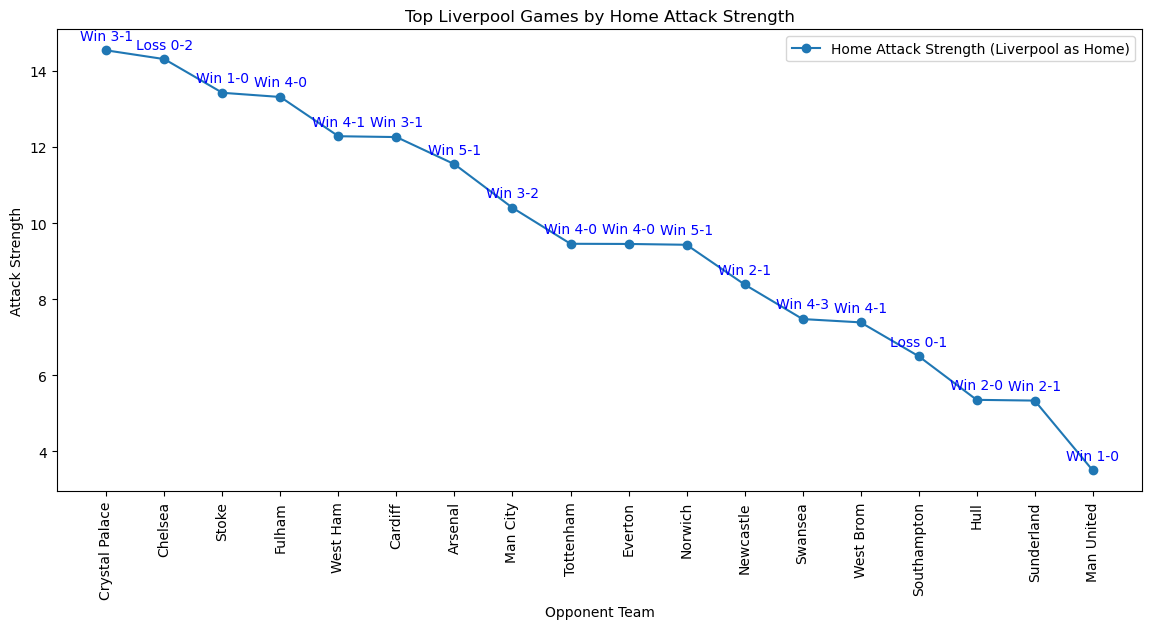

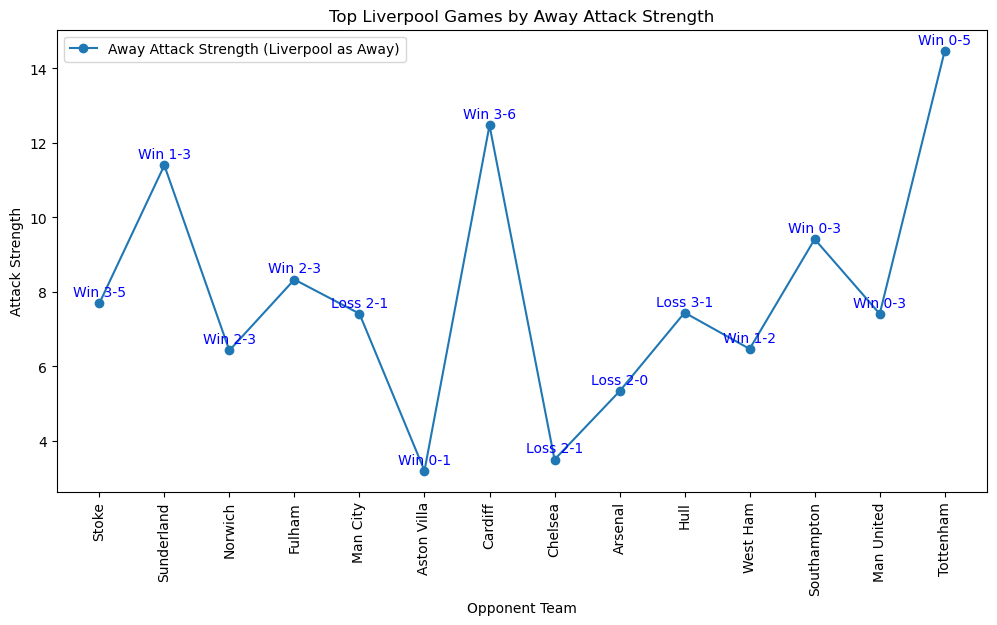

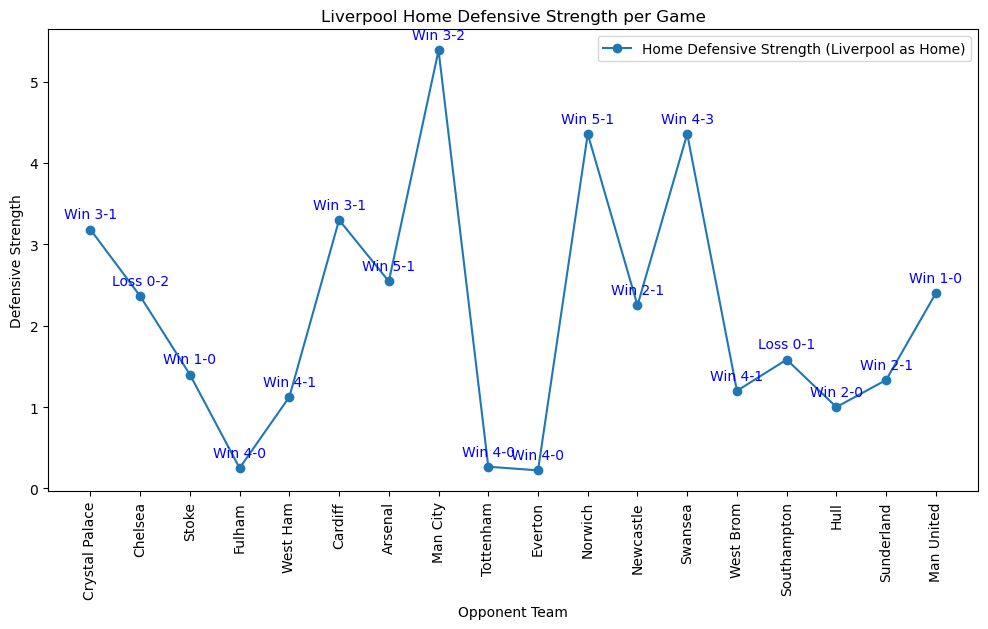

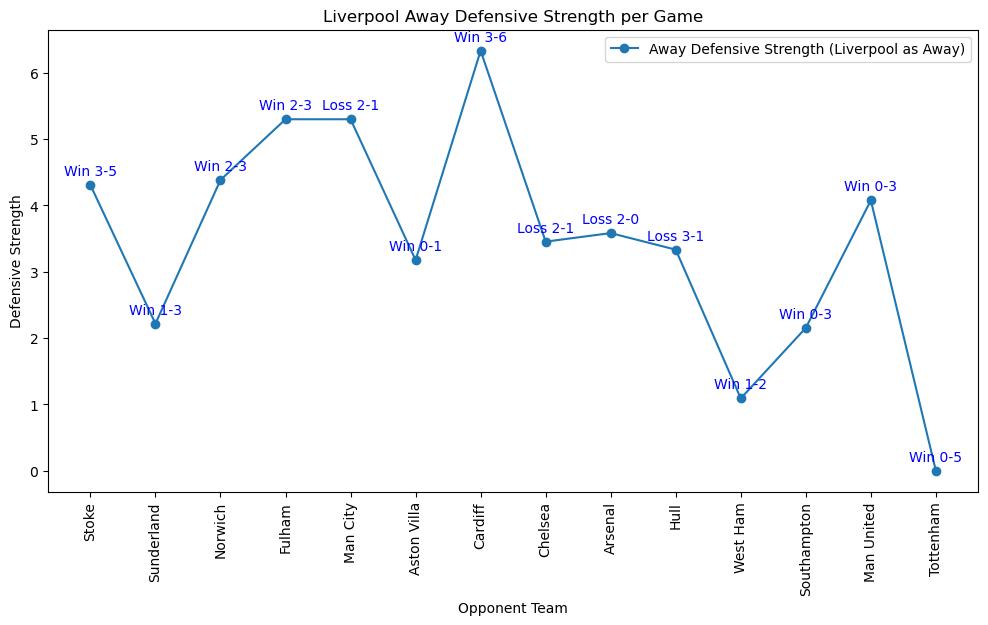

In [189]:
# Sort the matches by home_attack_strength and away_attack_strength
liverpool_matches_sorted = liverpool_matches_no_draws.sort_values(by=['home_attack_strength', 'away_attack_strength'], ascending=False)

# Create a new column for the opponent team
liverpool_matches_sorted['opponent_team'] = liverpool_matches_sorted.apply(
    lambda row: row['away_team'] if row['home_team'] == 'Liverpool' else row['home_team'], axis=1)

# Add a new column to indicate if Liverpool won or lost the game, including the score
liverpool_matches_sorted['result'] = liverpool_matches_sorted.apply(
    lambda row: f"Win {row['home_goals']}-{row['away_goals']}" if (row['home_team'] == 'Liverpool' and row['home_goals'] > row['away_goals']) or 
                (row['away_team'] == 'Liverpool' and row['away_goals'] > row['home_goals']) else 
                f"Loss {row['home_goals']}-{row['away_goals']}", axis=1)

# Filter for home games
home_games = liverpool_matches_sorted[liverpool_matches_sorted['home_team'] == 'Liverpool']

# Filter for away games
away_games = liverpool_matches_sorted[liverpool_matches_sorted['away_team'] == 'Liverpool']

# Plot Liverpool's home attack strength
plt.figure(figsize=(14, 6))
plt.plot(home_games['opponent_team'], home_games['home_attack_strength'], label='Home Attack Strength (Liverpool as Home)', marker='o')

# Annotate each point with the result (Win or Loss)
for i, row in home_games.iterrows():
    plt.text(row['opponent_team'], row['home_attack_strength'] + 0.2, row['result'], fontsize=10, ha='center', va='bottom', color='blue')

plt.title('Top Liverpool Games by Home Attack Strength')
plt.xlabel('Opponent Team')
plt.ylabel('Attack Strength')
plt.xticks(rotation=90)
plt.legend()
plt.show()

# Plot Liverpool's away attack strength
plt.figure(figsize=(12, 6))
plt.plot(away_games['opponent_team'], away_games['away_attack_strength'], label='Away Attack Strength (Liverpool as Away)', marker='o')

# Annotate each point with the result (Win or Loss) in blue color above the point
for i, row in away_games.iterrows():
    plt.text(row['opponent_team'], row['away_attack_strength'] + 0.1, row['result'], fontsize=10, ha='center', va='bottom', color='blue')

plt.title('Top Liverpool Games by Away Attack Strength')
plt.xlabel('Opponent Team')
plt.ylabel('Attack Strength')
plt.xticks(rotation=90)
plt.legend()
plt.show()

# Plot Liverpool's home defensive strength
plt.figure(figsize=(12, 6))
plt.plot(home_games['opponent_team'], home_games['home_defensive_strength'], label='Home Defensive Strength (Liverpool as Home)', marker='o')

# Annotate each point with the result (Win or Loss) in blue color above the point
for i, row in home_games.iterrows():
    plt.text(row['opponent_team'], row['home_defensive_strength'] + 0.1, row['result'], fontsize=10, ha='center', va='bottom', color='blue')

plt.title('Liverpool Home Defensive Strength per Game')
plt.xlabel('Opponent Team')
plt.ylabel('Defensive Strength')
plt.xticks(rotation=90)
plt.legend()
plt.show()

# Plot Liverpool's away defensive strength
plt.figure(figsize=(12, 6))
plt.plot(away_games['opponent_team'], away_games['away_defensive_strength'], label='Away Defensive Strength (Liverpool as Away)', marker='o')

# Annotate each point with the result (Win or Loss) in blue color above the point
for i, row in away_games.iterrows():
    plt.text(row['opponent_team'], row['away_defensive_strength'] + 0.1, row['result'], fontsize=10, ha='center', va='bottom', color='blue')

plt.title('Liverpool Away Defensive Strength per Game')
plt.xlabel('Opponent Team')
plt.ylabel('Defensive Strength')
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [190]:
liverpool_matches_no_draws

,date,home_team,away_team,home_goals,away_goals,ft_result,ht_home_goals,ht_away_goals,ht_result,referee,...,home_corners,away_corners,home_yellow_cards,away_yellow_cards,home_red_cards,away_red_cards,home_attack_strength,away_attack_strength,home_defensive_strength,away_defensive_strength
1,17/08/13,Liverpool,Stoke,1,0,H,1,0,H,M Atkinson,...,12,6,1,1,0,0,13.423077,6.400000,1.400000,2.423077
11,24/08/13,Aston Villa,Liverpool,0,1,A,0,1,A,M Clattenburg,...,8,2,3,3,0,0,8.176471,3.200000,4.200000,3.176471
28,01/09/13,Liverpool,Man United,1,0,H,1,0,H,A Marriner,...,2,7,2,4,0,0,3.500000,7.400000,2.400000,5.500000
41,21/09/13,Liverpool,Southampton,0,1,A,0,0,D,N Swarbrick,...,6,6,0,1,0,0,6.500000,7.583333,1.583333,1.500000
58,29/09/13,Sunderland,Liverpool,1,3,A,0,2,A,H Webb,...,10,8,2,1,0,0,11.217391,11.400000,5.400000,2.217391
63,05/10/13,Liverpool,Crystal Palace,3,1,H,3,0,H,A Taylor,...,11,3,2,1,0,0,14.538462,4.181818,3.181818,4.538462
82,26/10/13,Liverpool,West Brom,4,1,H,2,0,H,J Moss,...,3,9,0,2,0,0,7.388889,10.200000,1.200000,6.388889
90,02/11/13,Arsenal,Liverpool,2,0,H,1,0,H,M Atkinson,...,3,5,2,1,0,0,5.583333,5.333333,2.333333,3.583333
103,09/11/13,Liverpool,Fulham,4,0,H,3,0,H,M Jones,...,9,3,0,1,0,0,13.312500,3.250000,0.250000,5.312500
127,01/12/13,Hull,Liverpool,3,1,H,1,1,D,H Webb,...,2,6,2,0,0,0,5.333333,7.444444,3.444444,3.333333


In [191]:
# Define a function to check if Liverpool won
def check_liverpool_result(row):
    if row['home_goals'] > row['away_goals'] and row['home_team'] == 'Liverpool':
        return 1  # Liverpool won at home
    elif row['away_goals'] > row['home_goals'] and row['away_team'] == 'Liverpool':
        return 1  # Liverpool won away
    else:
        return 0  # Liverpool lost

# Apply the function to create a new 'liverpool_result' column
liverpool_matches_no_draws['liverpool_result'] = liverpool_matches_no_draws.apply(check_liverpool_result, axis=1)

# Display the updated dataframe
liverpool_matches_no_draws.head()


,date,home_team,away_team,home_goals,away_goals,ft_result,ht_home_goals,ht_away_goals,ht_result,referee,...,away_corners,home_yellow_cards,away_yellow_cards,home_red_cards,away_red_cards,home_attack_strength,away_attack_strength,home_defensive_strength,away_defensive_strength,liverpool_result
1,17/08/13,Liverpool,Stoke,1,0,H,1,0,H,M Atkinson,...,6,1,1,0,0,13.423077,6.400000,1.400000,2.423077,1
11,24/08/13,Aston Villa,Liverpool,0,1,A,0,1,A,M Clattenburg,...,2,3,3,0,0,8.176471,3.200000,4.200000,3.176471,1
28,01/09/13,Liverpool,Man United,1,0,H,1,0,H,A Marriner,...,7,2,4,0,0,3.500000,7.400000,2.400000,5.500000,1
41,21/09/13,Liverpool,Southampton,0,1,A,0,0,D,N Swarbrick,...,6,0,1,0,0,6.500000,7.583333,1.583333,1.500000,0
58,29/09/13,Sunderland,Liverpool,1,3,A,0,2,A,H Webb,...,8,2,1,0,0,11.217391,11.400000,5.400000,2.217391,1


In [192]:
liverpool_matches_no_draws

,date,home_team,away_team,home_goals,away_goals,ft_result,ht_home_goals,ht_away_goals,ht_result,referee,...,away_corners,home_yellow_cards,away_yellow_cards,home_red_cards,away_red_cards,home_attack_strength,away_attack_strength,home_defensive_strength,away_defensive_strength,liverpool_result
1,17/08/13,Liverpool,Stoke,1,0,H,1,0,H,M Atkinson,...,6,1,1,0,0,13.423077,6.400000,1.400000,2.423077,1
11,24/08/13,Aston Villa,Liverpool,0,1,A,0,1,A,M Clattenburg,...,2,3,3,0,0,8.176471,3.200000,4.200000,3.176471,1
28,01/09/13,Liverpool,Man United,1,0,H,1,0,H,A Marriner,...,7,2,4,0,0,3.500000,7.400000,2.400000,5.500000,1
41,21/09/13,Liverpool,Southampton,0,1,A,0,0,D,N Swarbrick,...,6,0,1,0,0,6.500000,7.583333,1.583333,1.500000,0
58,29/09/13,Sunderland,Liverpool,1,3,A,0,2,A,H Webb,...,8,2,1,0,0,11.217391,11.400000,5.400000,2.217391,1
63,05/10/13,Liverpool,Crystal Palace,3,1,H,3,0,H,A Taylor,...,3,2,1,0,0,14.538462,4.181818,3.181818,4.538462,1
82,26/10/13,Liverpool,West Brom,4,1,H,2,0,H,J Moss,...,9,0,2,0,0,7.388889,10.200000,1.200000,6.388889,1
90,02/11/13,Arsenal,Liverpool,2,0,H,1,0,H,M Atkinson,...,5,2,1,0,0,5.583333,5.333333,2.333333,3.583333,0
103,09/11/13,Liverpool,Fulham,4,0,H,3,0,H,M Jones,...,3,0,1,0,0,13.312500,3.250000,0.250000,5.312500,1
127,01/12/13,Hull,Liverpool,3,1,H,1,1,D,H Webb,...,6,2,0,0,0,5.333333,7.444444,3.444444,3.333333,0


In [193]:
# Drop the 'home_goals' and 'away_goals' columns from the dataframe
liverpool_matches_no_draws = liverpool_matches_no_draws.drop(columns=['home_goals', 'away_goals'])

# Create a new column 'liverpool_home_away' where 1 is for home and 0 is for away
liverpool_matches_no_draws['liverpool_home_away'] = liverpool_matches_no_draws.apply(
    lambda row: 1 if row['home_team'] == 'Liverpool' else 0, axis=1
)

In [194]:
liverpool_matches_no_draws

,date,home_team,away_team,ft_result,ht_home_goals,ht_away_goals,ht_result,referee,home_shots,away_shots,...,home_yellow_cards,away_yellow_cards,home_red_cards,away_red_cards,home_attack_strength,away_attack_strength,home_defensive_strength,away_defensive_strength,liverpool_result,liverpool_home_away
1,17/08/13,Liverpool,Stoke,H,1,0,H,M Atkinson,26,10,...,1,1,0,0,13.423077,6.400000,1.400000,2.423077,1,1
11,24/08/13,Aston Villa,Liverpool,A,0,1,A,M Clattenburg,17,5,...,3,3,0,0,8.176471,3.200000,4.200000,3.176471,1,0
28,01/09/13,Liverpool,Man United,H,1,0,H,A Marriner,10,10,...,2,4,0,0,3.500000,7.400000,2.400000,5.500000,1,1
41,21/09/13,Liverpool,Southampton,A,0,0,D,N Swarbrick,10,12,...,0,1,0,0,6.500000,7.583333,1.583333,1.500000,0,1
58,29/09/13,Sunderland,Liverpool,A,0,2,A,H Webb,23,15,...,2,1,0,0,11.217391,11.400000,5.400000,2.217391,1,0
63,05/10/13,Liverpool,Crystal Palace,H,3,0,H,A Taylor,13,11,...,2,1,0,0,14.538462,4.181818,3.181818,4.538462,1,1
82,26/10/13,Liverpool,West Brom,H,2,0,H,J Moss,18,15,...,0,2,0,0,7.388889,10.200000,1.200000,6.388889,1,1
90,02/11/13,Arsenal,Liverpool,H,1,0,H,M Atkinson,12,12,...,2,1,0,0,5.583333,5.333333,2.333333,3.583333,0,0
103,09/11/13,Liverpool,Fulham,H,3,0,H,M Jones,32,4,...,0,1,0,0,13.312500,3.250000,0.250000,5.312500,1,1
127,01/12/13,Hull,Liverpool,H,1,1,D,H Webb,12,9,...,2,0,0,0,5.333333,7.444444,3.444444,3.333333,0,0


In [195]:
liverpool_matches_no_draws['opponent_team'] = liverpool_matches_no_draws.apply(
    lambda row: row['away_team'] if row['home_team'] == 'Liverpool' else row['home_team'], axis=1
)

In [196]:
liverpool_matches_no_draws

,date,home_team,away_team,ft_result,ht_home_goals,ht_away_goals,ht_result,referee,home_shots,away_shots,...,away_yellow_cards,home_red_cards,away_red_cards,home_attack_strength,away_attack_strength,home_defensive_strength,away_defensive_strength,liverpool_result,liverpool_home_away,opponent_team
1,17/08/13,Liverpool,Stoke,H,1,0,H,M Atkinson,26,10,...,1,0,0,13.423077,6.400000,1.400000,2.423077,1,1,Stoke
11,24/08/13,Aston Villa,Liverpool,A,0,1,A,M Clattenburg,17,5,...,3,0,0,8.176471,3.200000,4.200000,3.176471,1,0,Aston Villa
28,01/09/13,Liverpool,Man United,H,1,0,H,A Marriner,10,10,...,4,0,0,3.500000,7.400000,2.400000,5.500000,1,1,Man United
41,21/09/13,Liverpool,Southampton,A,0,0,D,N Swarbrick,10,12,...,1,0,0,6.500000,7.583333,1.583333,1.500000,0,1,Southampton
58,29/09/13,Sunderland,Liverpool,A,0,2,A,H Webb,23,15,...,1,0,0,11.217391,11.400000,5.400000,2.217391,1,0,Sunderland
63,05/10/13,Liverpool,Crystal Palace,H,3,0,H,A Taylor,13,11,...,1,0,0,14.538462,4.181818,3.181818,4.538462,1,1,Crystal Palace
82,26/10/13,Liverpool,West Brom,H,2,0,H,J Moss,18,15,...,2,0,0,7.388889,10.200000,1.200000,6.388889,1,1,West Brom
90,02/11/13,Arsenal,Liverpool,H,1,0,H,M Atkinson,12,12,...,1,0,0,5.583333,5.333333,2.333333,3.583333,0,0,Arsenal
103,09/11/13,Liverpool,Fulham,H,3,0,H,M Jones,32,4,...,1,0,0,13.312500,3.250000,0.250000,5.312500,1,1,Fulham
127,01/12/13,Hull,Liverpool,H,1,1,D,H Webb,12,9,...,0,0,0,5.333333,7.444444,3.444444,3.333333,0,0,Hull


In [197]:
unique_opponent_teams = liverpool_matches_no_draws['opponent_team'].unique()

# Display the unique opponent teams
unique_opponent_teams

array(['Stoke', 'Aston Villa', 'Man United', 'Southampton', 'Sunderland',
       'Crystal Palace', 'West Brom', 'Arsenal', 'Fulham', 'Hull',
       'Norwich', 'West Ham', 'Tottenham', 'Cardiff', 'Man City',
       'Chelsea', 'Everton', 'Swansea', 'Newcastle'], dtype=object)

In [198]:
opponent_team_mapping = {team: i+2 for i, team in enumerate(unique_opponent_teams)}
liverpool_matches_no_draws['opponent_team_mapped'] = liverpool_matches_no_draws['opponent_team'].map(opponent_team_mapping)
opponent_team_mapping

{'Stoke': 2,
 'Aston Villa': 3,
 'Man United': 4,
 'Southampton': 5,
 'Sunderland': 6,
 'Crystal Palace': 7,
 'West Brom': 8,
 'Arsenal': 9,
 'Fulham': 10,
 'Hull': 11,
 'Norwich': 12,
 'West Ham': 13,
 'Tottenham': 14,
 'Cardiff': 15,
 'Man City': 16,
 'Chelsea': 17,
 'Everton': 18,
 'Swansea': 19,
 'Newcastle': 20}

In [199]:
opponent_team_mapping = {team: i+2 for i, team in enumerate(unique_opponent_teams)}
liverpool_matches_no_draws['opponent_team_mapped'] = liverpool_matches_no_draws['opponent_team'].map(opponent_team_mapping)
liverpool_matches_no_draws

,date,home_team,away_team,ft_result,ht_home_goals,ht_away_goals,ht_result,referee,home_shots,away_shots,...,home_red_cards,away_red_cards,home_attack_strength,away_attack_strength,home_defensive_strength,away_defensive_strength,liverpool_result,liverpool_home_away,opponent_team,opponent_team_mapped
1,17/08/13,Liverpool,Stoke,H,1,0,H,M Atkinson,26,10,...,0,0,13.423077,6.400000,1.400000,2.423077,1,1,Stoke,2
11,24/08/13,Aston Villa,Liverpool,A,0,1,A,M Clattenburg,17,5,...,0,0,8.176471,3.200000,4.200000,3.176471,1,0,Aston Villa,3
28,01/09/13,Liverpool,Man United,H,1,0,H,A Marriner,10,10,...,0,0,3.500000,7.400000,2.400000,5.500000,1,1,Man United,4
41,21/09/13,Liverpool,Southampton,A,0,0,D,N Swarbrick,10,12,...,0,0,6.500000,7.583333,1.583333,1.500000,0,1,Southampton,5
58,29/09/13,Sunderland,Liverpool,A,0,2,A,H Webb,23,15,...,0,0,11.217391,11.400000,5.400000,2.217391,1,0,Sunderland,6
63,05/10/13,Liverpool,Crystal Palace,H,3,0,H,A Taylor,13,11,...,0,0,14.538462,4.181818,3.181818,4.538462,1,1,Crystal Palace,7
82,26/10/13,Liverpool,West Brom,H,2,0,H,J Moss,18,15,...,0,0,7.388889,10.200000,1.200000,6.388889,1,1,West Brom,8
90,02/11/13,Arsenal,Liverpool,H,1,0,H,M Atkinson,12,12,...,0,0,5.583333,5.333333,2.333333,3.583333,0,0,Arsenal,9
103,09/11/13,Liverpool,Fulham,H,3,0,H,M Jones,32,4,...,0,0,13.312500,3.250000,0.250000,5.312500,1,1,Fulham,10
127,01/12/13,Hull,Liverpool,H,1,1,D,H Webb,12,9,...,0,0,5.333333,7.444444,3.444444,3.333333,0,0,Hull,11


In [200]:
liverpool_matches_no_draws.columns

Index(['date', 'home_team', 'away_team', 'ft_result', 'ht_home_goals',
       'ht_away_goals', 'ht_result', 'referee', 'home_shots', 'away_shots',
       'home_shots_on_target', 'away_shots_on_target', 'home_fouls',
       'away_fouls', 'home_corners', 'away_corners', 'home_yellow_cards',
       'away_yellow_cards', 'home_red_cards', 'away_red_cards',
       'home_attack_strength', 'away_attack_strength',
       'home_defensive_strength', 'away_defensive_strength',
       'liverpool_result', 'liverpool_home_away', 'opponent_team',
       'opponent_team_mapped'],
      dtype='object')

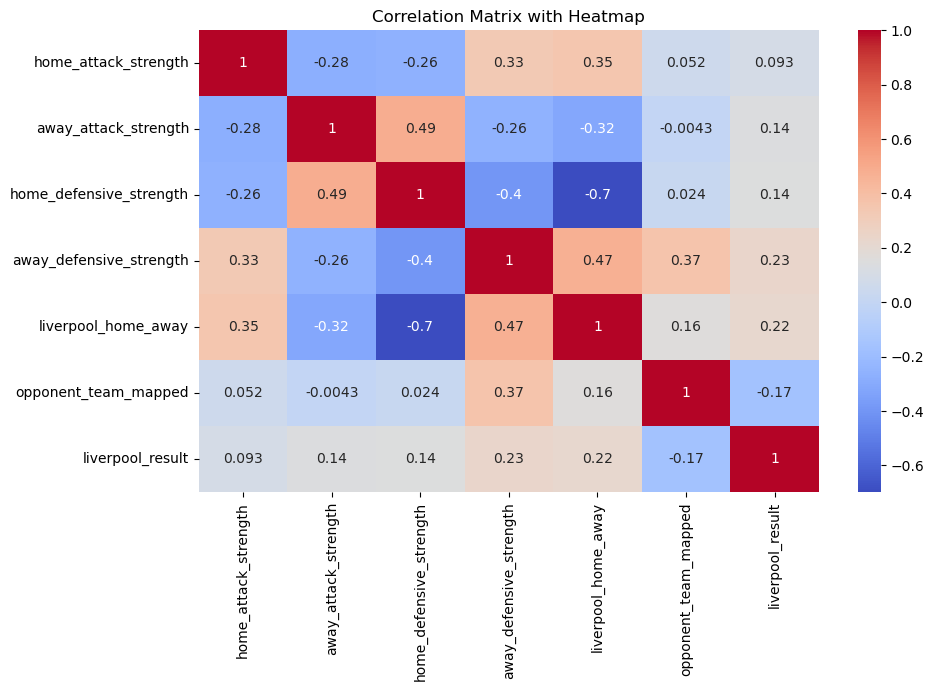

In [201]:
X = liverpool_matches_no_draws[['home_attack_strength', 'away_attack_strength', 'home_defensive_strength',
                                'away_defensive_strength', 'liverpool_home_away', 'opponent_team_mapped']]
y = liverpool_matches_no_draws['liverpool_result']


X['liverpool_result'] = y


correlation_matrix = X.corr()


plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix with Heatmap')
plt.show()


### Model training and evaluation

#### Random Forest

In [202]:

# Define the feature set and labels
X = liverpool_matches_no_draws[['home_attack_strength', 'away_attack_strength', 'home_defensive_strength',
                                'away_defensive_strength', 'liverpool_home_away', 'opponent_team_mapped']]
y = liverpool_matches_no_draws['liverpool_result']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Initialize and train the Random Forest classifier
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)

# Predict the results on the test set
y_pred_rf = rf_clf.predict(X_test)

# Calculate metrics for Random Forest
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
specificity_rf = conf_matrix_rf[0, 0] / (conf_matrix_rf[0, 0] + conf_matrix_rf[0, 1]) if (conf_matrix_rf[0, 0] + conf_matrix_rf[0, 1]) > 0 else 0
npv_rf = conf_matrix_rf[0, 0] / (conf_matrix_rf[0, 0] + conf_matrix_rf[1, 0]) if (conf_matrix_rf[0, 0] + conf_matrix_rf[1, 0]) > 0 else 0

# Display the results for Random Forest
print("Confusion Matrix:")
print(conf_matrix_rf)
print(f"Precision (TP/(all predicted positives): {precision_rf:.2f}")
print(f"Recall (TP/ all actual positives)      : {recall_rf:.2f}")
print(f"Specificity TN/(all actual negatives)  : {specificity_rf:.2f}")
print(f"Negative Predictive Value (TN/ All predicted negatives) (NPV): {npv_rf:.2f}")
print(f"Accuracy: {accuracy_rf:.2f}")


IndexError: index 1 is out of bounds for axis 1 with size 1

In [ ]:
# Predict the results on the entire dataset
y_pred_rf_full = rf_clf.predict(X)
# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Home/Away': liverpool_matches_no_draws['liverpool_home_away'].apply(lambda x: 'Yes' if x == 1 else 'No'),
    'Opponent': liverpool_matches_no_draws['opponent_team'],
    'Real Result': liverpool_matches_no_draws['liverpool_result'].apply(lambda x: 'Win' if x == 1 else 'Lose'),
    'Predicted Result': ['Win' if x == 1 else 'Lose' for x in y_pred_rf_full]
})
# Add a column to indicate if the prediction is correct
results_df['Correct Prediction'] = results_df['Real Result'] == results_df['Predicted Result']

# Calculate the cumulative points for real results
results_df['Real Points'] = (liverpool_matches_no_draws['liverpool_result'] * 3).cumsum()  # Assuming 3 points for a win

# Ensure y_pred_rf_full is a pandas Series with the same index as liverpool_matches_no_draws
y_pred_rf_full_series = pd.Series(y_pred_rf_full, index=liverpool_matches_no_draws.index)

# Calculate the points for predicted results (3 points for a win, 0 points for a loss)
predicted_points_rf = y_pred_rf_full_series.apply(lambda x: 3 if x == 1 else 0)

# Calculate the cumulative points for predicted results
results_df['Predicted Points'] = predicted_points_rf.cumsum()

# Display the results
results_df

## Phase II: Quantum Machine Learning Translation

## One qubit 

### Understanding the basics of quantum computing

Before diving into Quantum Machine Learning (QML), it's crucial to understand the basics of quantum computing and how it differs from classical computing.

 Key Concepts:

- **Qubits**: Unlike classical bits, which are either 0 or 1, qubits can simultaneously be in a superposition of both states. This allows quantum computers to process a vast amount of information more efficiently.
- **Quantum Gates**: Operations that manipulate qubits, such as the RX, RY, and RZ gates, which rotate qubits around the X, Y, and Z axes of the Bloch sphere.
- **Entanglement and Superposition**: These fundamental principles in quantum mechanics allow quantum computers to perform tasks infeasible for classical systems.
- **Measurement**: Once qubits have been manipulated using quantum gates, measuring them collapses the superposition into a definite state (0 or 1).

Our core idea is to encode classical data into quantum circuits and manipulate them using quantum gates. The classification task we are solving (predicting match results) involves translating classical features (like attack/defensive strengths) into quantum parameters that control the quantum gates.

### Translating classical features into quantum features

In this section, we normalize classical features like attack strength, defensive strength, and home/away status and convert them into quantum parameters to be used in a quantum circuit.

Steps:

1. **Normalization of Classical Features**: Classical features must be scaled to fit into quantum circuits. We normalize the classical data into a range [0, 1] so that they can be translated into rotation angles for quantum gates.

2. **Mapping Classical Features to Quantum Parameters**: Each normalized feature is mapped to a specific quantum gate parameter (θ1, θ2, etc.) and is used to rotate qubits along the X, Y, and Z axes.

In [ ]:
# Define the quantum parameters
theta1 = Parameter('θ1')
theta2 = Parameter('θ2')
theta3 = Parameter('θ3')
theta4 = Parameter('θ4')
theta5 = Parameter('θ5')
theta6 = Parameter('θ6')

# Create a quantum circuit with one qubit
qc = QuantumCircuit(1)

# Add parameterized gates to the quantum circuit
# Rotate the qubit around the X-axis by theta1
qc.rx(theta1, 0)
# Rotate the qubit around the Y-axis by theta2
qc.ry(theta2, 0)
# Rotate the qubit around the Z-axis by theta3
qc.rz(theta3, 0)
# Rotate the qubit around the X-axis by theta4
qc.rx(theta4, 0)
# Rotate the qubit around the Y-axis by theta5
qc.ry(theta5, 0)
# Rotate the qubit around the Z-axis by theta6
qc.rz(theta6, 0)

# Add a measurement to the quantum circuit
qc.measure_all()

print(qc.draw())


Here, we are mapping classical features to quantum gate parameters:

- **θ1** is derived from the normalized home attack strength.
- **θ2** is derived from the normalized away attack strength.
- **θ3** is derived from the normalized home defensive strength.
- **θ4** is derived from the normalized away defensive strength.
- **θ5** is derived from the home/away status.
- **θ6** is derived from the normalized opponent team mapping.

By scaling these parameters and applying them to the qubit using rotation gates (RX, RY, RZ), we encode the classical information into quantum states.

### Implementing and testing the quantum model 
This section focuses on constructing the quantum model based on the encoded quantum features and testing the model on the given dataset to classify match outcomes (win/loss).

Process:

1. **Quantum Circuit Construction**: We build a quantum circuit where the classical features are encoded into the quantum state via parameterized rotation gates.

2. **Execution on a Quantum Simulator**: After constructing the quantum circuit, we execute it on the QASM simulator (which mimics the behavior of a quantum processor). The circuit is run multiple times to gather measurement statistics.

3. **Classification Based on Measurements**: We classify the match result (win or loss) based on the measurement result. If the qubit measurement is more likely to be 0, we predict a loss; if it’s 1, we predict a win.

In [ ]:
def classify_match(home_attack_strength, away_attack_strength, home_defensive_strength, away_defensive_strength, home_away, opponent_team_mapped, label):
    # Normalize the input features to a range [0, 1]
    max_home_attack_strength = liverpool_matches_no_draws['home_attack_strength'].max()
    max_away_attack_strength = liverpool_matches_no_draws['away_attack_strength'].max()
    max_home_defensive_strength = liverpool_matches_no_draws['home_defensive_strength'].max()
    max_away_defensive_strength = liverpool_matches_no_draws['away_defensive_strength'].max()
    max_opponent_team_mapped = liverpool_matches_no_draws['away_team'].nunique()

    home_attack_strength_normalized = home_attack_strength / max_home_attack_strength
    away_attack_strength_normalized = away_attack_strength / max_away_attack_strength
    home_defensive_strength_normalized = home_defensive_strength / max_home_defensive_strength
    away_defensive_strength_normalized = away_defensive_strength / max_away_defensive_strength
    home_away_normalized = home_away  # Already binary, no need to normalize
    opponent_team_mapped_normalized = opponent_team_mapped / max_opponent_team_mapped

    # Map input features to theta values with adjusted scaling factors
    # θ1 is based on normalized home attack strength, scaled by π
    theta1_value = home_attack_strength_normalized * np.pi
    
    # θ2 is based on normalized away attack strength, scaled by π
    theta2_value = away_attack_strength_normalized * np.pi
    
    # θ3 is based on normalized home defensive strength, scaled by π
    theta3_value = home_defensive_strength_normalized * np.pi
    
    # θ4 is based on normalized away defensive strength, scaled by π
    theta4_value = away_defensive_strength_normalized * np.pi
    
    # θ5 is based on home/away status, scaled by π/2
    theta5_value = home_away_normalized * np.pi / 2
    
    # θ6 is based on normalized opponent team mapping, scaled by 2π/3
    theta6_value = opponent_team_mapped_normalized * 2 * np.pi / 3
    
    # Create a new quantum circuit with the mapped values
    bound_qc = QuantumCircuit(1)
    bound_qc.rx(theta1_value, 0)  # θ1
    bound_qc.ry(theta2_value, 0)  # θ2
    bound_qc.rz(theta3_value, 0)  # θ3
    bound_qc.rx(theta4_value, 0)  # θ4
    bound_qc.ry(theta5_value, 0)  # θ5
    bound_qc.rz(theta6_value, 0)  # θ6
    bound_qc.measure_all()

    # Execute the circuit on qasm_simulator for measurement
    backend = Aer.get_backend('qasm_simulator')
    compiled_circuit = transpile(bound_qc, backend)
    job = backend.run(compiled_circuit, shots=1024)
    result = job.result()

    # Get the counts
    counts = result.get_counts()

    # Visualize the results
    plot_histogram(counts)
    plt.show()

    # Classify based on the measurement result
    if counts.get('0', 0) > counts.get('1', 0):
        classification = 0  # Predicts loss
    else:
        classification = 1  # Predicts win

    return classification, label

#### Quantum Circuit Execution

The constructed quantum circuit is executed on the QASM simulator. The simulation is run multiple times (shots=1024) to gather the measurement statistics.

#### Classification Decision

Based on the counts of 0 and 1 from the measurement, the model classifies whether Liverpool won (1) or lost (0) the match.

#### Evaluating the Model

In [ ]:
# Iterate over the liverpool_matches_no_draws dataframe to classify each match
results = [classify_match(
    row['home_attack_strength'],
    row['away_attack_strength'],
    row['home_defensive_strength'],
    row['away_defensive_strength'],
    row['liverpool_home_away'],
    row['opponent_team_mapped'],
    row['liverpool_result']
) for index, row in liverpool_matches_no_draws.iterrows()]

# Extract the classifications and actual labels
classifications, labels = zip(*results)

# Calculate confusion matrix and metrics
conf_matrix = confusion_matrix(labels, classifications)
precision = precision_score(labels, classifications)
recall = recall_score(labels, classifications)
accuracy = accuracy_score(labels, classifications)
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1]) if (conf_matrix[0, 0] + conf_matrix[0, 1]) != 0 else float('nan')
npv = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[1, 0]) if (conf_matrix[0, 0] + conf_matrix[1, 0]) != 0 else float('nan')

# Display the results
print("Confusion Matrix:")
print(conf_matrix)
print(f"Precision (TP/(all predicted positives): {precision:.2f}")
print(f"Recall (TP/ all actual positives)      : {recall:.2f}")
print(f"Specificity TN/(all actual negatives)  : {specificity:.2f}")
print(f"Negative Predictive Value (TN/ All predicted negatives) (NPV): {npv:.2f}")
print(f"Accuracy: {accuracy:.2f}")

In [ ]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Loss', 'Predicted Win'], yticklabels=['Actual Loss', 'Actual Win'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Home/Away': liverpool_matches_no_draws['liverpool_home_away'].apply(lambda x: 'Yes' if x == 1 else 'No'),
    'Opponent': liverpool_matches_no_draws['opponent_team'],
    'Real Result': liverpool_matches_no_draws['liverpool_result'].apply(lambda x: 'Win' if x == 1 else 'Lose'),
    'Predicted Result': ['Win' if x == 1 else 'Lose' for x in classifications]
})

# Add a column to indicate if the prediction is correct
results_df['Correct Prediction'] = results_df['Real Result'] == results_df['Predicted Result']

# Calculate the cumulative points for real results
results_df['Real Points'] = (liverpool_matches_no_draws['liverpool_result'] * 3).cumsum()  # Assuming 3 points for a win

# Ensure classifications is a pandas Series with the same index as liverpool_matches_no_draws
classifications_series = pd.Series(classifications, index=liverpool_matches_no_draws.index)

# Calculate the points for predicted results (3 points for a win, 0 points for a loss)
predicted_points = classifications_series.apply(lambda x: 3 if x == 1 else 0)

# Calculate the cumulative points for predicted results
results_df['Predicted Points'] = predicted_points.cumsum()

# Display the results
results_df

After running the quantum model, we calculate the confusion matrix and metrics like precision, recall, and accuracy to assess the model's performance. These metrics provide insights into how well the quantum model performs in predicting match outcomes compared to the actual results.

## Multiple qubits

### Understanding the Basics of Quantum Computing for Multiple Qubits and Entanglement

In quantum computing, qubits are the basic unit of information, much like classical bits, but they can exist in a superposition of 0 and 1. The Hadamard (H) gate is used to put qubits into superposition, allowing them to exist in multiple states at once. Additionally, entanglement is a unique quantum property that links qubits together, so the state of one qubit is dependent on the state of another. Entanglement can be created using the CNOT (CX) gate.

In a multi-qubit system, we can use entanglement to capture relationships between different features of a dataset (such as home and away attack strengths), making the quantum model potentially more expressive than classical models

In [ ]:
# Define the quantum parameters
theta1 = Parameter('θ1')
theta2 = Parameter('θ2')
theta3 = Parameter('θ3')
theta4 = Parameter('θ4')
theta5 = Parameter('θ5')
theta6 = Parameter('θ6')

# Create a quantum circuit with multiple qubits
qc = QuantumCircuit(3)

# Add Hadamard gates to create superposition
qc.h(0)
qc.h(1)
qc.h(2)

# Add parameterized gates to the quantum circuit
qc.rx(theta1, 0)
qc.ry(theta2, 1)
qc.rz(theta3, 2)
qc.rx(theta4, 0)
qc.ry(theta5, 1)
qc.rz(theta6, 2)

# Add CNOT gates to create entanglement
qc.cx(0, 1)
qc.cx(1, 2)

# Add a measurement to the quantum circuit
qc.measure_all()

qc.draw()


### Translating Classical Features into Quantum Features

In Quantum Machine Learning (QML), classical features are translated into quantum gate parameters. For instance, normalized features such as attack strength and defensive strength are used to determine the rotation angles of the qubits. The rotation gates (RX, RY, and RZ) manipulate the qubits according to the feature values.

For this example, we normalize the input features (like home and away attack strength) to a [0, 1] range and map these normalized values to angles for quantum gates. These angles are used to rotate the qubits in the quantum circuit.

In [ ]:

def classify_match(home_attack_strength, away_attack_strength, home_defensive_strength, away_defensive_strength, home_away, opponent_team_mapped, label):
    # Normalize the input features to a range [0, 1]
    max_home_attack_strength = liverpool_matches_no_draws['home_attack_strength'].max()
    max_away_attack_strength = liverpool_matches_no_draws['away_attack_strength'].max()
    max_home_defensive_strength = liverpool_matches_no_draws['home_defensive_strength'].max()
    max_away_defensive_strength = liverpool_matches_no_draws['away_defensive_strength'].max()
    max_opponent_team_mapped = liverpool_matches_no_draws['away_team'].nunique() 

    home_attack_strength_normalized = home_attack_strength / max_home_attack_strength
    away_attack_strength_normalized = away_attack_strength / max_away_attack_strength
    home_defensive_strength_normalized = home_defensive_strength / max_home_defensive_strength
    away_defensive_strength_normalized = away_defensive_strength / max_away_defensive_strength
    home_away_normalized = home_away  # Already binary, no need to normalize
    opponent_team_mapped_normalized =   opponent_team_mapped / max_opponent_team_mapped
    

    # Map input features to theta values with adjusted scaling factors
    # For continuous features, use larger angles, but not too aggressive
    theta1_value = home_attack_strength_normalized * np.pi / 2  # Scale down the rotation for attack strength
    theta2_value = away_attack_strength_normalized * np.pi / 2
    theta3_value = home_defensive_strength_normalized * np.pi / 2
    theta4_value = away_defensive_strength_normalized * np.pi / 2

    # For binary features, use smaller rotations to avoid over-rotation
    theta5_value = home_away_normalized * np.pi / 6  # Smaller scaling for home/away status (binary)
    theta6_value = opponent_team_mapped_normalized * 2 * np.pi / 3  # Adjusted scaling for team mapping

    # Create a new quantum circuit with 3 qubits representing different features
    bound_qc = QuantumCircuit(3)
    
    # Apply Hadamard gates to each qubit to create superposition
    # This allows each qubit to be in a state of both 0 and 1 simultaneously
    bound_qc.h(0)
    bound_qc.h(1)
    bound_qc.h(2)

    # Apply parameterized rotation gates to the qubits, based on the input feature values
    bound_qc.rx(theta1_value, 0)  # Rotate qubit 0 (representing home attack) around the X-axis
    bound_qc.ry(theta2_value, 1)  # Rotate qubit 1 (representing away attack) around the Y-axis
    bound_qc.rz(theta3_value, 2)  # Rotate qubit 2 (representing home defense) around the Z-axis
    bound_qc.rx(theta4_value, 0)  # Rotate qubit 0 again based on away defense
    bound_qc.ry(theta5_value, 1)  # Rotate qubit 1 again based on home/away status
    bound_qc.rz(theta6_value, 2)  # Rotate qubit 2 based on opponent team

    # Apply CNOT gates to entangle the qubits, meaning their states will be dependent on each other
    # This allows the model to capture relationships between the features (e.g., home and away attack and defense strengths)
    bound_qc.cx(0, 1)
    bound_qc.cx(1, 2)

    # Measure the qubits to collapse them into definite states (0 or 1) based on their probabilities
    bound_qc.measure_all()
    
    # Execute the circuit on qasm_simulator for measurement
    backend = Aer.get_backend('qasm_simulator')
    compiled_circuit = transpile(bound_qc, backend)
    job = backend.run(compiled_circuit, shots=1024)
    result = job.result()

    # Get the counts
    counts = result.get_counts()

    # Visualize the results
    plot_histogram(counts)
    plt.show()

    # Classify based on the measurement result
    if counts.get('0', 0) > counts.get('1', 0):
        classification = 0  # Predicts loss
    else:
        classification = 1  # Predicts win

    return classification, label

### Implementing and Testing the Quantum Model

Once we’ve translated classical features into quantum features, we can execute the quantum circuit on a simulator (such as IBM’s QASM simulator) and classify the match outcome based on the measurement results. The qubits are measured after applying quantum gates, and the result is classified as a win or loss based on the most frequent measurement outcome.

We use standard classification metrics like precision, recall, and accuracy to evaluate the performance of the quantum model.

In [ ]:
# Iterate over the liverpool_matches_no_draws dataframe to classify each match
results = [classify_match(
    row['home_attack_strength'],
    row['away_attack_strength'],
    row['home_defensive_strength'],
    row['away_defensive_strength'],
    row['liverpool_home_away'],
    row['opponent_team_mapped'],
    row['liverpool_result']
) for index, row in liverpool_matches_no_draws.iterrows()]

# Extract the classifications and actual labels
classifications, labels = zip(*results)

print("Classification results:", results)
print("Actual labels:", labels)

In [ ]:

# Calculate confusion matrix and metrics
conf_matrix = confusion_matrix(labels, classifications)
precision = precision_score(labels, classifications)
recall = recall_score(labels, classifications)
accuracy = accuracy_score(labels, classifications)
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1]) if (conf_matrix[0, 0] + conf_matrix[0, 1]) != 0 else float('nan')
npv = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[1, 0]) if (conf_matrix[0, 0] + conf_matrix[1, 0]) != 0 else float('nan')

# Display the results
print("Confusion Matrix:")
print(conf_matrix)
print(f"Precision (TP/(all predicted positives): {precision:.2f}")
print(f"Recall (TP/ all actual positives)      : {recall:.2f}")
print(f"Specificity TN/(all actual negatives)  : {specificity:.2f}")
print(f"Negative Predictive Value (TN/ All predicted negatives) (NPV): {npv:.2f}")
print(f"Accuracy: {accuracy:.2f}")

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Loss', 'Predicted Win'], yticklabels=['Actual Loss', 'Actual Win'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import pandas as pd

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Home/Away': liverpool_matches_no_draws['liverpool_home_away'].apply(lambda x: 'Yes' if x == 1 else 'No'),
    'Opponent': liverpool_matches_no_draws['opponent_team'],
    'Real Result': liverpool_matches_no_draws['liverpool_result'].apply(lambda x: 'Win' if x == 1 else 'Lose'),
    'Predicted Result': ['Win' if x == 1 else 'Lose' for x in classifications]
})

# Add a column to indicate if the prediction is correct
results_df['Correct Prediction'] = results_df['Real Result'] == results_df['Predicted Result']

# Calculate the cumulative points for real results
results_df['Real Points'] = (liverpool_matches_no_draws['liverpool_result'] * 3).cumsum()  # Assuming 3 points for a win

# Ensure classifications is a pandas Series with the same index as liverpool_matches_no_draws
classifications_series = pd.Series(classifications, index=liverpool_matches_no_draws.index)

# Calculate the points for predicted results (3 points for a win, 0 points for a loss)
predicted_points = classifications_series.apply(lambda x: 3 if x == 1 else 0)

# Calculate the cumulative points for predicted results
results_df['Predicted Points'] = predicted_points.cumsum()

# Display the results
results_df

## Phase III: Naive Bayes in Classical and Quantum Methods

### Implementing Naive Bayes in a Classical Setting


In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score

# Assuming X_train, X_test, y_train, and y_test are already defined

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the Gaussian Naive Bayes classifier
gnb = GaussianNB()

# Train the classifier
gnb.fit(X_train_scaled, y_train)

# Predict the results on the test set
y_pred_gnb = gnb.predict(X_test_scaled)

# Calculate metrics for Classical Naive Bayes
conf_matrix_gnb = confusion_matrix(y_test, y_pred_gnb)
precision_gnb = precision_score(y_test, y_pred_gnb)
recall_gnb = recall_score(y_test, y_pred_gnb)
accuracy_gnb = accuracy_score(y_test, y_pred_gnb)
specificity_gnb = conf_matrix_gnb[0, 0] / (conf_matrix_gnb[0, 0] + conf_matrix_gnb[0, 1]) if (conf_matrix_gnb[0, 0] + conf_matrix_gnb[0, 1]) != 0 else float('nan')
npv_gnb = conf_matrix_gnb[0, 0] / (conf_matrix_gnb[0, 0] + conf_matrix_gnb[1, 0]) if (conf_matrix_gnb[0, 0] + conf_matrix_gnb[1, 0]) != 0 else float('nan')

# Display the results for Classical Naive Bayes
print("Confusion Matrix (Classical Naive Bayes):")
print(conf_matrix_gnb)
print(f"Precision (TP/(all predicted positives): {precision_gnb:.2f}")
print(f"Recall (TP/ all actual positives)      : {recall_gnb:.2f}")
print(f"Specificity TN/(all actual negatives)  : {specificity_gnb:.2f}")
print(f"Negative Predictive Value (TN/ All predicted negatives) (NPV): {npv_gnb:.2f}")
print(f"Accuracy: {accuracy_gnb:.2f}")

### Translating the Naive Bayes Algorithm to a Quantum Framework

In [ ]:
# import numpy as np
# from qiskit_aer import Aer
# from qiskit.circuit.library import RealAmplitudes
# from qiskit.utils import QuantumInstance
# from qiskit_machine_learning.algorithms import VQC
# from qiskit_machine_learning.kernels import QuantumKernel
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score

# # Assuming X_train, X_test, y_train, and y_test are already defined

# # Standardize the features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # Define the quantum feature map
# feature_map = RealAmplitudes(num_qubits=6, reps=2)

# # Define the variational form (ansatz)
# var_form = RealAmplitudes(num_qubits=6, reps=2)

# # Define the quantum instance
# quantum_instance = QuantumInstance(Aer.get_backend('qasm_simulator'))

# # Initialize the VQC
# vqc = VQC(feature_map=feature_map, var_form=var_form, optimizer=None, quantum_instance=quantum_instance)

# # Train the VQC
# vqc.fit(X_train_scaled, y_train)

# # Predict the results on the test set
# y_pred_vqc = vqc.predict(X_test_scaled)

# # Calculate metrics for Quantum Naive Bayes
# conf_matrix_vqc = confusion_matrix(y_test, y_pred_vqc)
# precision_vqc = precision_score(y_test, y_pred_vqc)
# recall_vqc = recall_score(y_test, y_pred_vqc)
# accuracy_vqc = accuracy_score(y_test, y_pred_vqc)
# specificity_vqc = conf_matrix_vqc[0, 0] / (conf_matrix_vqc[0, 0] + conf_matrix_vqc[0, 1]) if (conf_matrix_vqc[0, 0] + conf_matrix_vqc[0, 1]) != 0 else float('nan')
# npv_vqc = conf_matrix_vqc[0, 0] / (conf_matrix_vqc[0, 0] + conf_matrix_vqc[1, 0]) if (conf_matrix_vqc[0, 0] + conf_matrix_vqc[1, 0]) != 0 else float('nan')

# # Display the results for Quantum Naive Bayes
# print("Confusion Matrix (Quantum Naive Bayes):")
# print(conf_matrix_vqc)
# print(f"Precision (TP/(all predicted positives): {precision_vqc:.2f}")
# print(f"Recall (TP/ all actual positives)      : {recall_vqc:.2f}")
# print(f"Specificity TN/(all actual negatives)  : {specificity_vqc:.2f}")
# print(f"Negative Predictive Value (TN/ All predicted negatives) (NPV): {npv_vqc:.2f}")
# print(f"Accuracy: {accuracy_vqc:.2f}")

In [ ]:
# from qiskit_aer import Aer
# from qiskit.circuit.library import RealAmplitudes
# from qiskit.utils import QuantumInstance
# from qiskit_machine_learning.algorithms import QSVC
# from qiskit_machine_learning.kernels import QuantumKernel
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score

# # Assuming X_train, X_test, y_train, and y_test are already defined

# # Standardize the features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # Define the quantum feature map
# feature_map = RealAmplitudes(num_qubits=6, reps=2)

# # Create the quantum kernel
# quantum_kernel = QuantumKernel(feature_map=feature_map, quantum_instance=QuantumInstance(Aer.get_backend('qasm_simulator')))

# # Initialize and train the quantum SVM classifier
# qsvc = QSVC(quantum_kernel=quantum_kernel)
# qsvc.fit(X_train_scaled, y_train)

# # Predict the results on the test set
# y_pred_qsvc = qsvc.predict(X_test_scaled)

# # Calculate metrics for Quantum SVM
# conf_matrix_qsvc = confusion_matrix(y_test, y_pred_qsvc)
# precision_qsvc = precision_score(y_test, y_pred_qsvc, average='weighted')
# recall_qsvc = recall_score(y_test, y_pred_qsvc, average='weighted')
# accuracy_qsvc = accuracy_score(y_test, y_pred_qsvc)
# specificity_qsvc = conf_matrix_qsvc[0, 0] / (conf_matrix_qsvc[0, 0] + conf_matrix_qsvc[0, 1]) if (conf_matrix_qsvc[0, 0] + conf_matrix_qsvc[0, 1]) != 0 else float('nan')
# npv_qsvc = conf_matrix_qsvc[0, 0] / (conf_matrix_qsvc[0, 0] + conf_matrix_qsvc[1, 0]) if (conf_matrix_qsvc[0, 0] + conf_matrix_qsvc[1, 0]) != 0 else float('nan')

# # Display the results for Quantum SVM
# print("Confusion Matrix (Quantum SVM):")
# print(conf_matrix_qsvc)
# print(f"Precision (TP/(all predicted positives): {precision_qsvc:.2f}")
# print(f"Recall (TP/ all actual positives)      : {recall_qsvc:.2f}")
# print(f"Specificity TN/(all actual negatives)  : {specificity_qsvc:.2f}")
# print(f"Negative Predictive Value (TN/ All predicted negatives) (NPV): {npv_qsvc:.2f}")
# print(f"Accuracy: {accuracy_qsvc:.2f}")

### Comparing the Results and Performance of Both Methods

In [ ]:
# # Display the comparison of results
# print("\nComparison of Naive Bayes (Classical) and Quantum SVM:")
# print(f"{'Metric':<30}{'Naive Bayes':<20}{'Quantum SVM':<20}")
# print(f"{'Confusion Matrix':<30}{conf_matrix_nb}{conf_matrix_qsvc}")
# print(f"{'Precision':<30}{precision_nb:.2f}{precision_qsvc:.2f}")
# print(f"{'Recall':<30}{recall_nb:.2f}{recall_qsvc:.2f}")
# print(f"{'Specificity':<30}{specificity_nb:.2f}{specificity_qsvc:.2f}")
# print(f"{'NPV':<30}{npv_nb:.2f}{npv_qsvc:.2f}")
# print(f"{'Accuracy':<30}{accuracy_nb:.2f}{accuracy_qsvc:.2f}")

In [ ]:
!jupyter nbconvert --to html "final-project-pro.ipynb"